In [15]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import multi_rake
import re
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from multi_rake import Rake
import nltk
import csv
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag

In [16]:
BB = pd.read_csv('/Users/jiaruizhang/Desktop/reviews/coding/after sort.csv')
BB = BB.sort_index()
BB

,content,star,sku,label
0,its a bagit holds candy not included trick or ...,5,8566349,1
1,the bag would be a great deal if it was availa...,1,8566349,0
2,loved the movie and it played ok was delivered...,5,6083463,1
3,as a guy i cant say im headoverheels for dirty...,3,6083463,0
4,this movie is great for all ages shipping was ...,5,8977805,1
...,...,...,...,...
154,i bought this as a christmas gift for a family...,5,3792604,0
155,our purchase was as a christmas gift for our g...,5,3792604,1
156,this is just a quick note for anyone who was c...,4,3792604,1
157,stargate sg the entire series just amazing to ...,5,8553399,0


In [17]:
product = BB.sku.nunique()
occur = BB.groupby('sku').count()
occur.label.max()

7

In [18]:
from nltk import FreqDist
import seaborn as sns
def clean_text_r3(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stemmer = nltk.stem.WordNetLemmatizer()
    text = " ".join(stemmer.lemmatize(token)for token in tokens)
    return text
round3 = lambda x: clean_text_r3(x)
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    return d

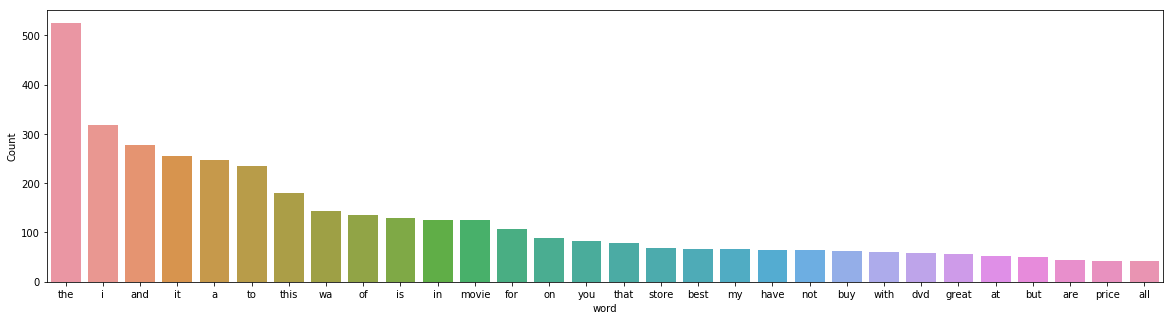

,word,count
29,the,525
51,i,319
63,and,277
0,it,256
1,a,247
26,to,235
13,this,181
35,wa,144
42,of,135
45,is,129


In [19]:
BB = pd.DataFrame(BB.content.apply(round3))
freq_words(BB['content'])

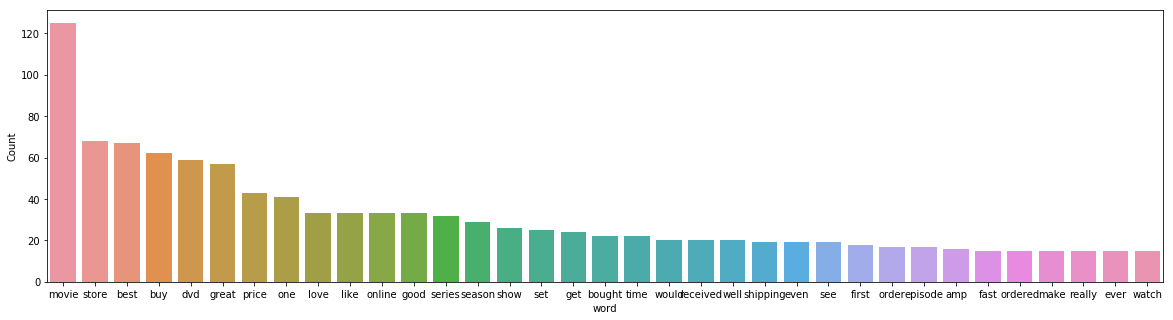

,word,count
37,movie,125
23,store,68
69,best,67
70,buy,62
59,dvd,59
20,great,57
26,price,43
7,one,41
50,love,33
217,like,33


In [20]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new
# remove short words (length < 3)
BB['content'] = BB['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# remove stopwords from the text
overall_reviews = [remove_stopwords(r.split()) for r in BB['content']]
freq_words(overall_reviews, 35)
# To further remove noise from the text we can use lemmatization from the spaCy library. 
# It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [21]:
import spacy
import gensim
from gensim import corpora
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
tokenized_overall = pd.Series(overall_reviews).apply(lambda x: x.split())
dictionary = corpora.Dictionary(tokenized_overall)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_overall]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.20973066880886088


In [22]:
import numpy as np
import tqdm
# supporting function
corpus=doc_term_matrix
id2word=dictionary
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
#beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=1600)
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_overall.csv', index=False)
    pbar.close()


 10%|▉         | 152/1600 [02:11<23:49,  1.01it/s]


 19%|█▉        | 303/1600 [04:43<20:11,  1.07it/s]


 28%|██▊       | 454/1600 [07:24<22:38,  1.19s/it]


 38%|███▊      | 605/1600 [10:17<15:49,  1.05it/s]


 47%|████▋     | 756/1600 [13:12<17:24,  1.24s/it]


 57%|█████▋    | 907/1600 [15:49<09:24,  1.23it/s]


 66%|██████▌   | 1057/1600 [18:16<10:30,  1.16s/it]


 75%|███████▌  | 1205/1600 [20:55<06:29,  1.01it/s]


 85%|████████▍ | 1353/1600 [23:32<04:36,  1.12s/it]


 94%|█████████▍| 1501/1600 [26:18<01:50,  1.12s/it]


100%|██████████| 1600/1600 [28:12<00:00,  1.06s/it]


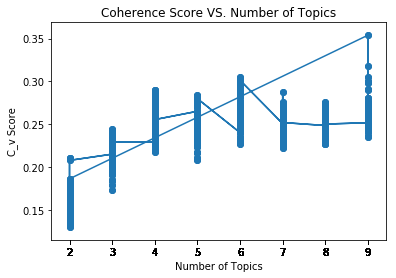

In [27]:
# filter the results
results_for_vis = pd.read_csv("lda_tuning_results_overall.csv")
#results_for_vis = results[results["Alpha"]!='symmetric']
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='symmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='asymmetric']

# now the plot
import matplotlib.pyplot as plt
plt.plot(np.array(results_for_vis["Topics"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Topics"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Number of Topics")
plt.title("Coherence Score VS. Number of Topics")
plt.xticks(np.array(results_for_vis["Topics"]))
plt.show()

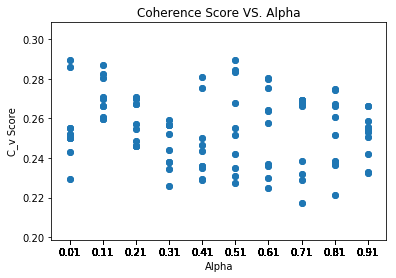

In [28]:
results = pd.read_csv("lda_tuning_results_overall.csv")
results_for_vis = results[results["Topics"]==4]
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='asymmetric']

# now the plot
import matplotlib.pyplot as plt
#plt.plot(np.array(results_for_vis["Alpha"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Alpha"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Alpha")
plt.title("Coherence Score VS. Alpha")
plt.xticks(np.array(results_for_vis["Alpha"]))
plt.show()
# 0.81 0.91

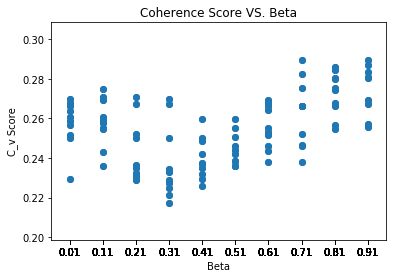

In [29]:
results = pd.read_csv("lda_tuning_results_overall.csv")
results_for_vis = results[results["Topics"]==4]
#results_for_vis = results_for_vis[results_for_vis["Alpha"]!='asymmetric']
#results_for_vis = results_for_vis[results_for_vis["Beta"]!='asymmetric']

# now the plot
import matplotlib.pyplot as plt
#plt.plot(np.array(results_for_vis["Alpha"]), np.array(results_for_vis["Coherence"]))
plt.scatter(np.array(results_for_vis["Beta"]), np.array(results_for_vis["Coherence"]))
plt.ylabel("C_v Score")
plt.xlabel("Beta")
plt.title("Coherence Score VS. Beta")
plt.xticks(np.array(results_for_vis["Beta"]))
plt.show()
# 0.81 0.91

In [30]:
# k = 4, a = 0.51, b = 0.71
tokenized_overall = pd.Series(overall_reviews).apply(lambda x: x.split())
dictionary = corpora.Dictionary(tokenized_overall)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_overall]
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.51,
                                           eta=0.71)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis
pyLDAvis.save_html(vis, 'BB_overall_sep_4.html')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [31]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,corpus=doc_term_matrix, texts=tokenized_overall,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2896923373531719


In [14]:
id2word=dictionary
model_cnt = [0,0,0,0]
temp_1,temp_2,temp_3,temp_4 = 0, 0, 0, 0
for i in range(len(overall_reviews)):
    corpus_1= [ id2word.doc2bow(word_tokenize(doc)) for doc in overall_reviews[i] ]
    temp_model = lda_model[corpus_1]
    temp_1,temp_2,temp_3,temp_4 = 0, 0, 0, 0
    for j in range(len(overall_reviews[i])):
        temp_1 += temp_model[j][0][1]
        temp_2 += temp_model[j][1][1]
        temp_3 += temp_model[j][2][1]
        temp_4 += temp_model[j][3][1]
model_cnt[0] = temp_1/len(overall_reviews[i])
model_cnt[1] = temp_2/len(overall_reviews[i])
model_cnt[2] = temp_3/len(overall_reviews[i])
model_cnt[3] = temp_4/len(overall_reviews[i])
print(len(model_cnt),len(overall_reviews))

4 159


In [16]:
BB['topic 0'] = 0
BB['topic 1'] = np.nan
BB['topic 2'] = np.nan
BB['topic 3'] = np.nan
BB['topic 4'] = np.nan
for i in range(len(overall_reviews)):
    if i != 132:
        corpus_1= [id2word.doc2bow(word_tokenize(overall_reviews[i]))]
        temp_model = lda_model[corpus_1]
        BB.at[i, 'topic 1'] = temp_model[0][0][1]
        BB.at[i, 'topic 2'] = temp_model[0][1][1]
        BB.at[i, 'topic 3'] = temp_model[0][2][1]
        BB.at[i, 'topic 4'] = temp_model[0][3][1]
BB

,content,topic 0,topic 1,topic 2,topic 3,topic 4
0,bagit hold candy not included trick treat you ...,0,0.049003,0.054975,0.836163,0.059820
1,the bag would great deal available for store p...,0,0.045464,0.769235,0.141662,0.043622
2,loved the movie and played delivered ontime,0,0.127310,0.475198,0.278962,0.118439
3,guy cant say headoverheels for dirty dancing b...,0,0.052961,0.859685,0.042853,0.044535
4,this movie great for all age shipping extremel...,0,0.097252,0.360818,0.232729,0.307918
...,...,...,...,...,...,...
154,bought this christmas gift for family with fou...,0,0.024849,0.904371,0.040904,0.029867
155,our purchase christmas gift for our granddaugh...,0,0.029676,0.895512,0.042010,0.032798
156,this just quick note for anyone who concerned ...,0,0.075129,0.752204,0.103079,0.069574
157,stargate the entire series just amazing able w...,0,0.031970,0.884520,0.034811,0.048702


In [ ]:
# The y values.  A numpy array is used here,
# but a python list could also be used.
fair_y = [0,0.25,0.25,0.25]
fair_y_cum = np.cumsum(fair_y)
fair_area = np.trapz(fair_y_cum, dx=5)
BB['area'] = np.nan
BB['GINI coe'] = np.nan
for i in range(len(overall_reviews)):
    y = []
    for j in range(5):
        temp = 'topic '+str(j)
        y.append(BB.at[i,temp])
        # [0, 0.0532762, 0.06006141, 0.8866621]
        y_cum = np.cumsum(y)
        # [0.  0.05327629 0.11333771 0.99999983]
        BBarea = np.trapz(y_cum, dx=4)
        BB.at[i, 'area'] = BBarea
        BB.at[i, 'GINI coe'] = (fair_area - BBarea)/fair_area
BB